# Experiment 1: Retaining weight on Mnist dataset. 
**In this task we implement a simple NN, optimize it, and plot histogram of retain probabilities of Variational Dropout Layer.**

In [1]:
from matplotlib import image
from matplotlib.pyplot import imread
from IPython import display

import os
import time

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# For loading mnist dataset
from utils import load_mnist

# Implemented parts
from Models import Radamacher_Regularization_p_inf_q_1
from Models import iterate_minibatches
from Models import Flatten
from Models import VariationalDropout
from Models import compute_loss

# Load data

In [2]:
X_train, _, y_train, _ = load_mnist()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# Rescaling
X_train = X_train / 255
X_test = X_test / 255

X_train.shape, y_train.shape

((33600, 28, 28), (33600,))

Label:  8


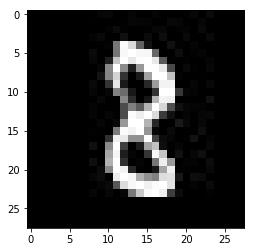

In [3]:
print('Label: ', y_train[3000])
plt.imshow(X_train[3000].reshape((28, 28)), cmap='gray')
plt.show()

In [4]:
X_train = torch.Tensor(X_train).cuda()
y_train = torch.tensor(y_train, dtype=torch.int64).cuda()

X_test = torch.Tensor(X_test).cuda()
y_test = torch.tensor(y_test, dtype = torch.int64).cuda()

In [5]:
y_train.dtype

torch.int64

In [6]:
def compute_loss(logits, y_batch):
    return F.cross_entropy(logits, y_batch).mean()

# Training

In [7]:
def train(model, X_train, y_train, num_epochs, batch_size, optimizer, scheduler, random_seed = 123):
    
    np.random.seed(random_seed)
    
    initial_rates = []
    hidden_rates = []
    
    train_loss = []
    train_loss_per_epoch = []
    
    train_extra_loss_per_epoch = []
    
    model.train(True) # enable dropout / batch_norm training behavior

    for epoch in range(num_epochs):
        scheduler.step()
        
        start_time = time.time()

        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
                
            logits = model(X_batch)
            loss_net = compute_loss(logits, y_batch)
            loss_reg = Radamacher_Regularization_p_inf_q_1(model, X_batch)
            loss = loss_net + regularizer_weights * loss_reg
            
            train_loss.append(float(loss))
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            

        train_loss_per_epoch.append(np.mean(train_loss[-batch_size :]))
        
        initial_rates.append(model[-5].probs.data.cpu())
        hidden_rates.append(model[-2].probs.data.cpu())    
    
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Cross-entropy loss")
        plt.xlabel("number of epoch")
        plt.ylabel("loss")
        plt.plot(train_loss_per_epoch, 'b', label = "Training")
        plt.legend()
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss: \t{:.6f}".format(train_loss_per_epoch[-1]))

    return train_loss_per_epoch, initial_rates, hidden_rates

In [8]:
torch.random.manual_seed(123)

input_initial_rates = torch.Tensor([0.8] * 784).cuda()
hidden_initial_rates = torch.Tensor([0.5] * 1024).cuda()

model = nn.Sequential(Flatten(),
                      VariationalDropout(input_initial_rates, mode='deterministic'),
                      torch.nn.Linear(784, 1024),
                      torch.nn.ReLU(), 
                      VariationalDropout(hidden_initial_rates, mode='deterministic'),
                      torch.nn.Linear(1024, 10), 
                     )

model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

n_optimization_iter_to_upd_lr = 200
multiplicative_factor_lr = 0.5

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_optimization_iter_to_upd_lr, 
                                           gamma=multiplicative_factor_lr)
num_epochs = 700
batch_size = 100


extra_loss_func = Radamacher_Regularization_p_inf_q_1
regularizer_weights = 1e-4

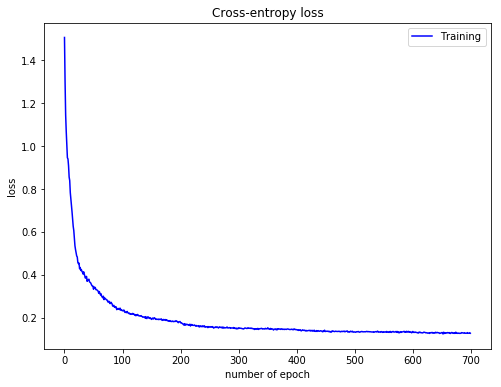

Epoch 700 of 700 took 0.997s
  training loss: 	0.127854


In [9]:
train_loss_per_epoch, initial_rates, hidden_rates = train(model, X_train[:20000], y_train[:20000], 
                num_epochs, batch_size, optimizer, scheduler)

In [10]:
initial_rates_new = []
hidden_rates_new = []

for it in initial_rates:
    initial_rates_new.append(it.numpy())
    
for it in hidden_rates:
    hidden_rates_new.append(it.numpy())

In [11]:
initial_rates_new = np.array(initial_rates_new)
hidden_rates_new = np.array(hidden_rates_new)

In [12]:
np.save("initial_rates.npy", initial_rates_new)
np.save("hidden_rates.npy", hidden_rates_new)

(array([488.,  71.,  68.,  43.,  47.,  41.,  12.,   6.,   4.,   4.]),
 array([0.79057598, 0.79989517, 0.80921437, 0.81853356, 0.82785275,
        0.83717194, 0.84649113, 0.85581033, 0.86512952, 0.87444871,
        0.8837679 ]),
 <a list of 10 Patch objects>)

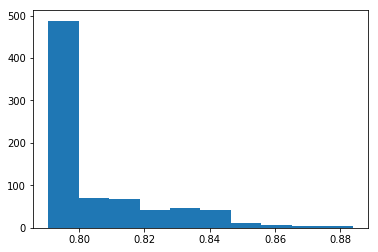

In [13]:
plt.hist(initial_rates_new[0])

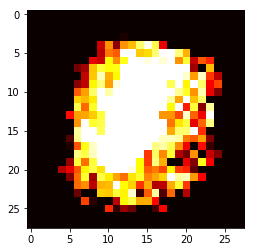

In [14]:
plt.imshow(initial_rates[-1].numpy().reshape((28, 28)), cmap = 'hot')

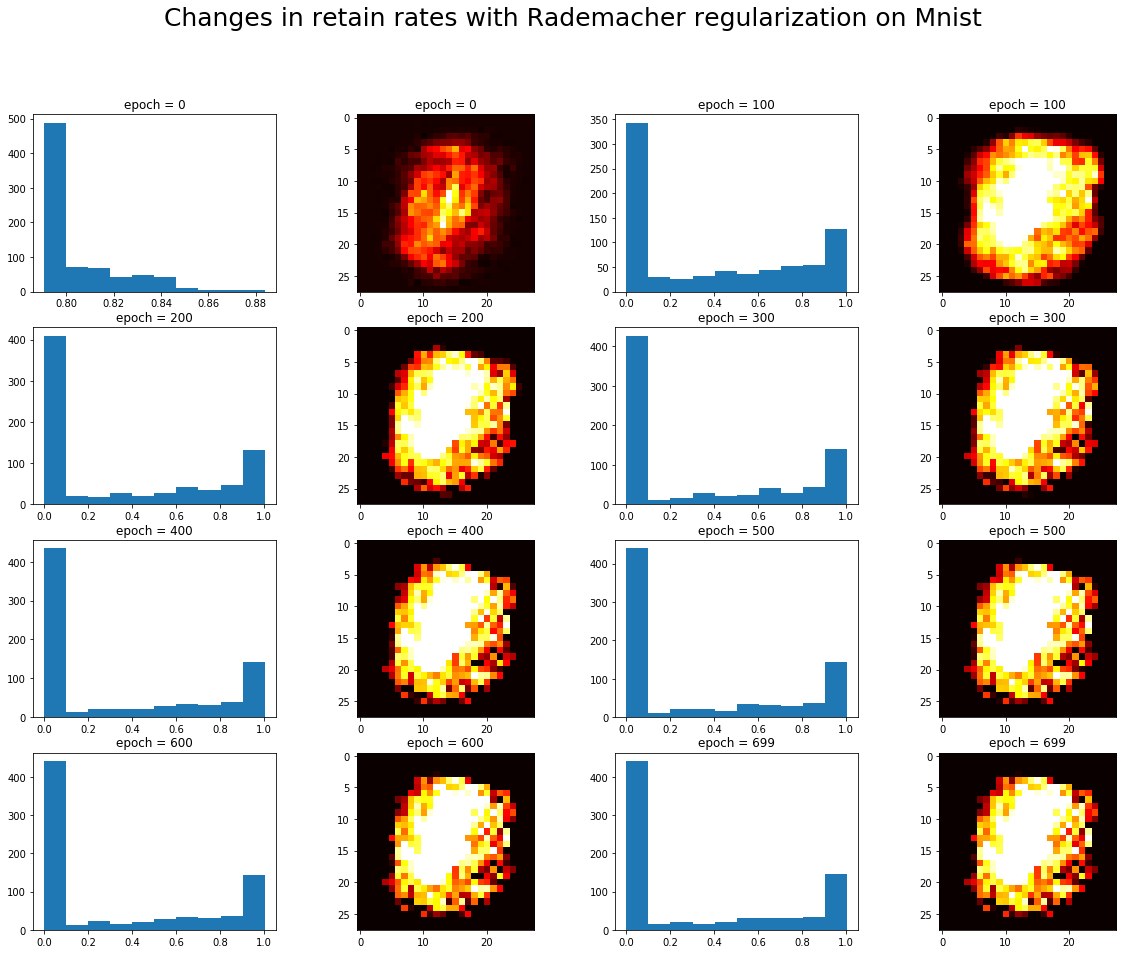

In [15]:
fig = plt.figure(figsize = (20, 15))
plt.suptitle("Changes in retain rates with Rademacher regularization on Mnist", size = 25)

for it, dim in enumerate([0, 100, 200, 300, 400, 500, 600, 699]):
    ax = fig.add_subplot(4, 4, 2*it + 1)
    ax.hist(initial_rates_new[dim])
    ax.set_title("epoch = {}".format(dim))
    ax = fig.add_subplot(4, 4, 2*it + 2)
    ax.imshow(initial_rates_new[dim].reshape((28, 28)), cmap = 'hot')
    ax.set_title("epoch = {}".format(dim))

#plt.tight_layout()
plt.show()

**As we can see we have a good rate of convergence. Now plot histogram and heatmap for retain probabilities. We can observe that the retain rates converged towards a bimodal distribution. In our case we have one global mode at 0 and one local mode at 1. Empirically, when debugging and testing we observed that for some architectures of NN and initial points and optimization strategies, proportions of modes can be different. Heatmap shows that center pizels often have larger retain rates. This demonstrates that this method is avle to dynamically determine if an input signal is informational or not.**

In [16]:
model.train(False)

test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_train, y_train, 500):
    logits = model(X_batch)
    y_pred = logits.max(1)[1]
    test_batch_acc.append(torch.sum(y_batch == y_pred).cpu().data.numpy() / y_batch.shape[0])

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("Train accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

Final results:
Train accuracy:		97.97 %


In [17]:
model.train(False)

test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(X_batch)
    y_pred = logits.max(1)[1]
    test_batch_acc.append(torch.sum(y_batch == y_pred).cpu().data.numpy() / y_batch.shape[0])

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("Test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

Final results:
Test accuracy:		96.51 %


**As we can see, that model shows a pretty good result on test and it's overfitting is very small dur to Rademacher regularizer. We may obtain better result on Mnist, if we consider more powerful architecture and train our net for a little bit more time.**